In [11]:
%load_ext autoreload
%autoreload 2
# imports
import logging
import sys, os
import time
from tf_pose import common
import cv2
import numpy as np
from tf_pose.estimator import TfPoseEstimator, PoseEstimator
from tf_pose.networks import get_graph_path, model_wh
from tf_pose.common import CocoPart, CocoPairsRender, CocoPairsNetwork
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import asyncio
import datetime
import random
import websockets
import nest_asyncio
import http.server
import socketserver
import threading
from IPython.display import IFrame
import base64
from PIL import Image
from io import BytesIO
import re
from utils import plot_pose, get_humans_as_lines, plot_human_lines, is_same_image
import tensorflow as tf
import math
import copy
sys.path.insert(0, os.path.abspath('..'))
# Import DeepExplain
from deepexplain.tf.v1_x import DeepExplain
from tf_pose.tensblur.smoother import Smoother
from cleverhans.attacks import FastGradientMethod

nest_asyncio.apply()

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)
logging.getLogger('TfPoseEstimatorRun').setLevel(logging.ERROR)
logging.getLogger('DeepExplain').setLevel(logging.ERROR)
logging.getLogger('TfPoseEstimator').setLevel(logging.ERROR)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# params 432, 368
w, h = 432, 368
image_path_source = './data/images/lea_source.jpg'
image_path_target = './data/images/lea_target_near.jpg'
model = 'cmu'
resize_out_ratio = 2.0
image_source = common.read_imgfile(image_path_source, w, h)
image_target = common.read_imgfile(image_path_target, w, h)

In [3]:
e_source = TfPoseEstimator(get_graph_path(model), target_size=(w, h), trt_bool=False)
e_target = TfPoseEstimator(get_graph_path(model), target_size=(w, h), trt_bool=False)
upsample_size = [int(e_target.target_size[1] / 8 * resize_out_ratio), int(e_target.target_size[0] / 8 * resize_out_ratio)]

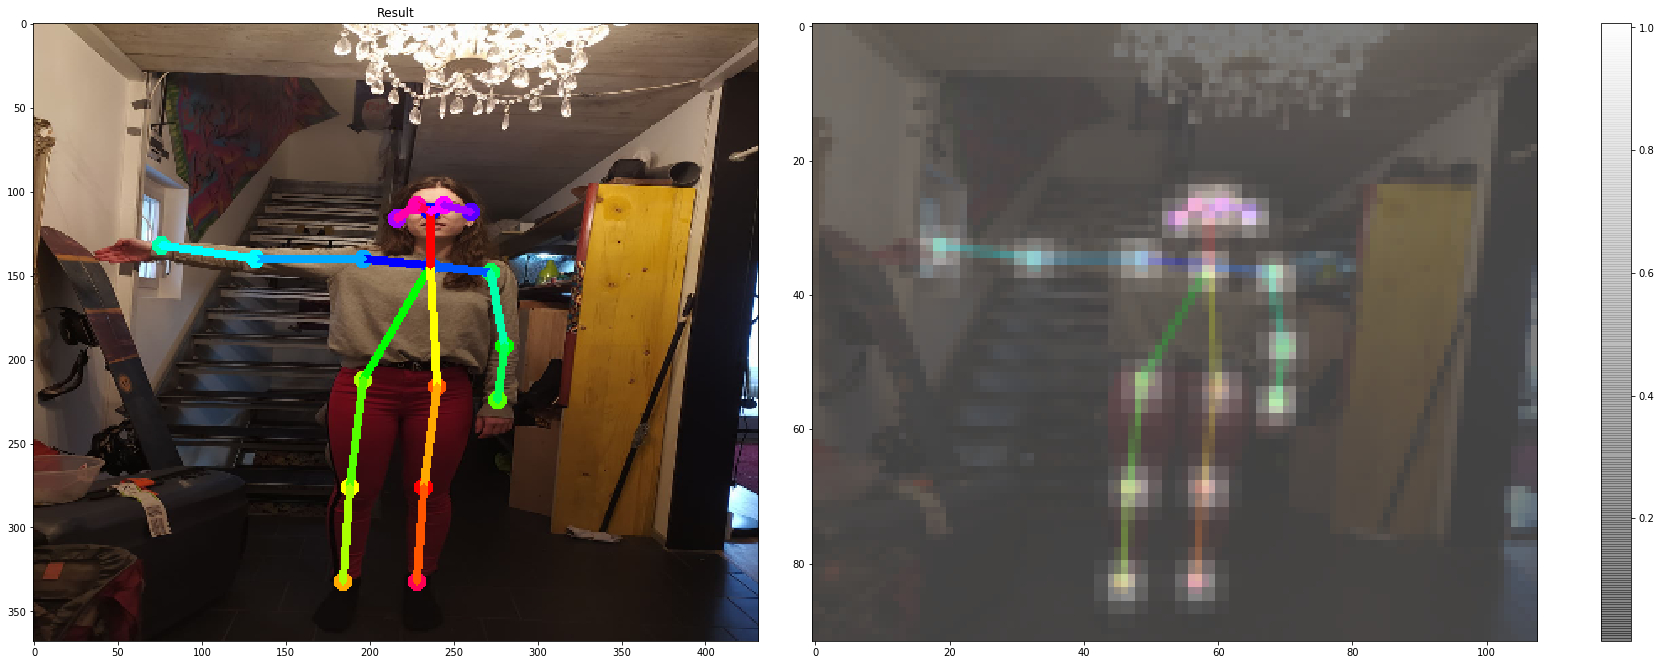

In [4]:
human_source = e_source.inference(image_source, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)
plot_pose(image_source, human_source, e_source.heatMat)

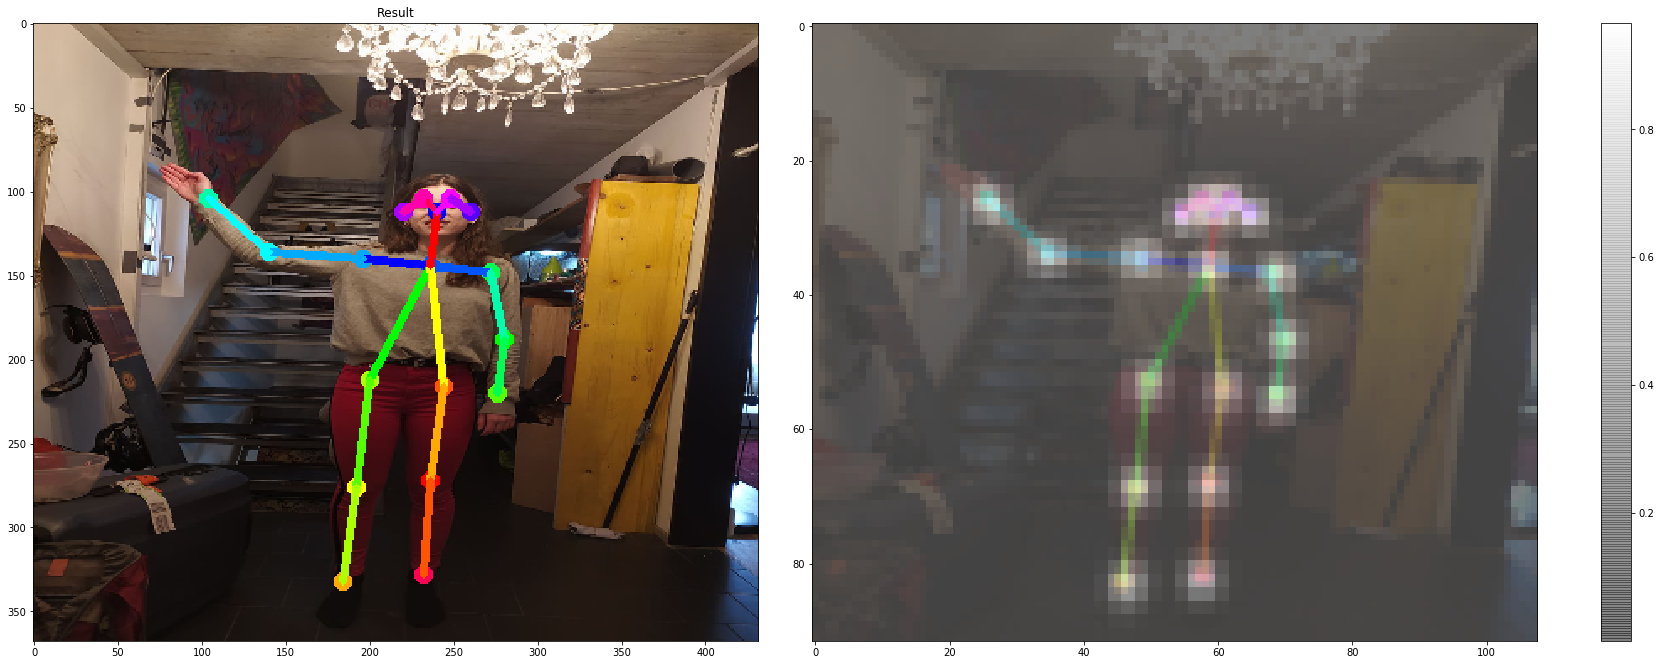

In [5]:
human_target = e_target.inference(image_target, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)
plot_pose(image_target, human_target, e_target.heatMat)

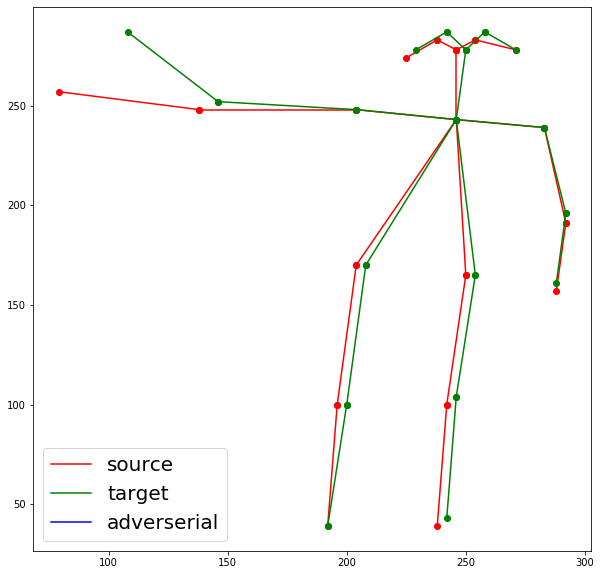

In [6]:
source_lines = get_humans_as_lines(human_source, 400, 450)
target_lines = get_humans_as_lines(human_target, 400, 450)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

plot_human_lines(source_lines, ax, color='r', linestyle='-', label='source')
plot_human_lines(target_lines, ax, color='g', linestyle='-', label='target')

legend_elements = [Line2D([0], [0], color='r', label='source'),
                   Line2D([0], [0], color='g', label='target'),
                   Line2D([0], [0], color='b', label='adverserial')]
ax.legend(handles=legend_elements, loc='best',  prop={'size': 20})

In [7]:
# get all outputs as np matrix
target_np, target_np_heat, target_np_paf, target_np_peaks = e_target.persistent_sess.run(
            [e_target.tensor_output, e_target.tensor_heatMat_up, e_target.tensor_pafMat_up, e_target.tensor_peaks],
            feed_dict={
                e_target.tensor_image: [image_target],
                e_target.upsample_size: upsample_size
            }
        )

source_np, source_np_heat, source_np_paf, source_np_peaks = e_source.persistent_sess.run(
            [e_source.tensor_output, e_source.tensor_heatMat_up, e_source.tensor_pafMat_up, e_source.tensor_peaks],
            feed_dict={
                e_source.tensor_image: [image_source],
                e_source.upsample_size: upsample_size
            }
        )


In [8]:
ONLY_HEAT = True
USE_PEAK_AS_HEAT = False
# change only the heatmap for the wrist and the required limb vector field
# wrist
temp_target = copy.deepcopy(source_np_heat)
if USE_PEAK_AS_HEAT:
    temp_target[:, :, :, CocoPart.RWrist.value] = target_np_heat[:, :, :, CocoPart.RWrist.value]
else:
    temp_target[:, :, :, CocoPart.RWrist.value] = target_np_peaks[:, :, :, CocoPart.RWrist.value]

target_np_heat = temp_target


# lower arm 
temp_target = copy.deepcopy(source_np_paf)
if ONLY_HEAT:
    LOWER_ARM_RIGTH = 3
    id = CocoPairsNetwork[LOWER_ARM_RIGTH][0]
    temp_target[:, :, :, id] = target_np_paf[:, :, :, id]
    temp_target[:, :, :, id + 1] = target_np_paf[:, :, :, id + 1]

target_np_paf = temp_target

# set the correct peaks
temp_target = copy.deepcopy(source_np_peaks)
temp_target[:, :, :, CocoPart.RWrist.value] = target_np_peaks[:, :, :, CocoPart.RWrist.value]
target_np_peaks = temp_target

# change the output as well
temp_target = copy.deepcopy(source_np)
temp_target[:, :, :, CocoPart.RWrist.value] = target_np[:, :, :, CocoPart.RWrist.value]
if ONLY_HEAT:
    temp_target[:, :, :, id + 19] = target_np[:, :, :, id + 19]
    temp_target[:, :, :, id + 19 + 1] = target_np[:, :, :, id + 19 + 1]
target_np = temp_target

(1, 46, 54, 57)
(1, 92, 108, 19)
(1, 92, 108, 38)
(1, 92, 108, 19)


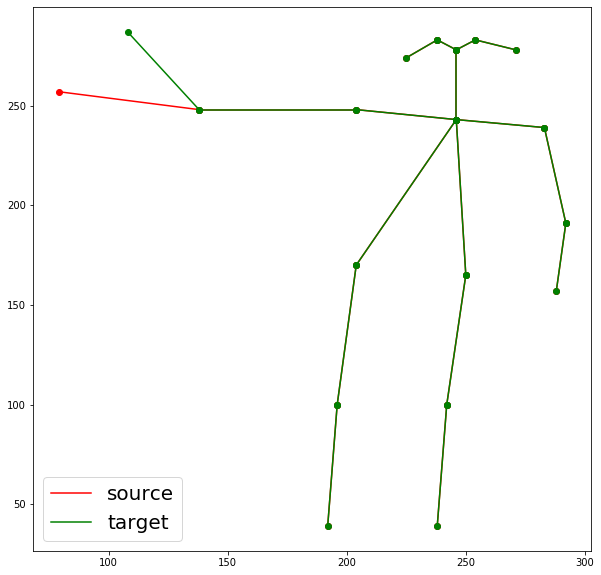

In [9]:
print(target_np.shape)
print(target_np_heat.shape)
print(target_np_paf.shape)
print(target_np_peaks.shape)

# for i in range(52):
#     print(np.sum(np.abs(target_np[:, :, :, i] - source_np[:, :, :, i])))


human_source = PoseEstimator.estimate_paf(source_np_peaks[0], source_np_heat[0], source_np_paf[0])
human_target = PoseEstimator.estimate_paf(target_np_peaks[0], target_np_heat[0], target_np_paf[0])


source_lines = get_humans_as_lines(human_source, 400, 450)
target_lines = get_humans_as_lines(human_target, 400, 450)


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

plot_human_lines(source_lines, ax, color='r', linestyle='-', label='source')
plot_human_lines(target_lines, ax, color='g', linestyle='-', label='target')

legend_elements = [Line2D([0], [0], color='r', label='source'),
                   Line2D([0], [0], color='g', label='target')]
ax.legend(handles=legend_elements, loc='best',  prop={'size': 20})

In [10]:
fgsm = FastGradientMethod(model, sess=e_source.persistent_sess)
fgsm_params = {
      'eps': 0.3,
      'clip_min': 0.,
      'clip_max': 1.
  }

In [ ]:
adv_x = fgsm.generate(x, **fgsm_params)